In [1]:
from pixell import enmap, enplot, utils, curvedsky
from cosmikyu import maps, config
from cosmikyu import utils as cutils
from soapack import interfaces as soint
import healpy as hp
import numpy as np
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
output_dir = config.default_data_dir
def output_path(x):
    return os.path.join(output_dir, x)

In [3]:
sehgal_sim_path = soint.dconfig['actsims']['sehgal09_path']
SH = maps.SehgalSky2010(sehgal_sim_path, data_type='alm')

freq_idxes = ['030', '090', '148', '219', '277', '350']
fg_loaders = {
    'ir_pts': SH.get_cib,
    'ksz': SH.get_ksz,
    'rad_pts': SH.get_radio,
    'tsz': SH.get_tsz   
}

npix = 150
res = 2 *utils.arcmin
fshape, fwcs = enmap.fullsky_geometry(res)
template = maps.get_template(fshape, fwcs)

for freq_idx in freq_idxes:
    for fg_idx in fg_loaders.keys():
        target_file = output_path('{}/{}_meta.txt'.format(fg_idx, freq_idx))
        if os.path.exists(target_file):
            print("skipping {} {}".format(freq_idx, fg_idx))
        else:
            print("processing {} {}".format(freq_idx, fg_idx))
            os.makedirs(output_path(fg_idx), exist_ok=True)
            
            alm = fg_loaders[fg_idx](freq_idx)
            fgmap = curvedsky.alm2map(alm, template.copy())
            meta = np.array([np.mean(fgmap), np.std(fgmap), np.max(fgmap), np.min(fgmap)])
            np.savetxt(target_file, meta, header="mean,std,max,min",
                       comments="#[{} F{} 0.5 arcmin res]   ".format(fg_idx.upper(), freq_idx))
            
            del alm, fgmap
            
#sign = np.sign(fgmap)
#fgmap = np.log(np.abs(fgmap))*sign
            
def load_meta(fg_idxes, freq_idxes):
    ret = cutils.create_dict(fg_idxes, freq_idxes)
    for freq_idx in freq_idxes:
        for fg_idx in fg_loaders.keys():
            target_file = output_path('{}/{}_meta.txt'.format(fg_idx, freq_idx)) 
            mmean, mstd, mmax, mmin = np.loadtxt(target_file)
            ret[fg_idx][freq_idx] = {'mean': mmean, 'std': mstd, 'max': mmax , 'min': mmin}
    return ret
    
metas = load_meta(list(fg_loaders.keys()), freq_idxes)
for fg_idx in fg_loaders.keys():
    for freq_idx in metas[fg_idx].keys():
        print(fg_idx, freq_idx, metas[fg_idx][freq_idx])
    


skipping 030 ir_pts
skipping 030 ksz
skipping 030 rad_pts
skipping 030 tsz
skipping 090 ir_pts
skipping 090 ksz
skipping 090 rad_pts
skipping 090 tsz
skipping 148 ir_pts
skipping 148 ksz
skipping 148 rad_pts
skipping 148 tsz
skipping 219 ir_pts
skipping 219 ksz
skipping 219 rad_pts
skipping 219 tsz
skipping 277 ir_pts
skipping 277 ksz
skipping 277 rad_pts
skipping 277 tsz
skipping 350 ir_pts
skipping 350 ksz
skipping 350 rad_pts
skipping 350 tsz
ir_pts 030 {'mean': 34.04549400407869, 'std': 29.18152531528908, 'max': 1962.4244099098073, 'min': -279.6274886596626}
ir_pts 090 {'mean': 1356.5323079135794, 'std': 1174.415770589677, 'max': 68714.10429188391, 'min': -9749.374288827685}
ir_pts 148 {'mean': 6723.7384318853765, 'std': 5802.902664354928, 'max': 348620.8448433348, 'min': -47906.45000015797}
ir_pts 219 {'mean': 21881.05272039636, 'std': 18976.60609857938, 'max': 1174320.0997806764, 'min': -186649.57752546904}
ir_pts 277 {'mean': 41986.01840417685, 'std': 37355.620383476635, 'max': 

In [10]:
#stamp_width = stamp_height = 256*0.5*utils.arcmin
stamp_width = stamp_height = npix*res
shape, wcs, _ = maps.rand_geometry(stamp_width, stamp_height, res=res)
print(shape, wcs)

for freq_idx in freq_idxes:
    for fg_idx in fg_loaders.keys():
        alm = fg_loaders[fg_idx](freq_idx)
        fgmap = curvedsky.alm2map(alm, template.copy()); del alm
        for sim_idx in np.arange(3096):
            target_file = output_path('stamp_{}arcmin_{}x{}/{}_{}_{}_{}arcmin_{}x{}.fits'.format(
                '2.0', npix, npix, freq_idx, fg_idx,'%06d'%sim_idx, '2.0', npix, npix))
            #ntarget_file = output_path('stamp_{}arcmin_{}x{}/{}_{}_{}_{}arcmin_{}x{}.fits'.format(
            #   '2.0', npix, npix, freq_idx, fg_idx,'%06d'%sim_idx, '2.0',npix, npix))

            if os.path.exists(target_file):
                continue
                #os.rename(target_file, ntarget_file)
                #print("help")
            else:
                if sim_idx %100 == 0:
                    print("generating {}".format(target_file))
                
                _, _, pos = maps.rand_geometry(stamp_width, stamp_height, shape=shape, seed=sim_idx)
                stamp = enmap.submap(fgmap, pos)
                if shape != stamp.shape: 
                    assert(False)
                enmap.write_fits(target_file, stamp); del stamp
                
                #print(pos, enmap.submap(template, pos).shape)
                #temp = enmap.extract(fgmap, shape=shape, wcs=wcs)
                #enmap.write_fits(target_file, temp); del temp
 
        del fgmap

(150, 150) car:{cdelt:[0.03333,0.03333],crval:[30.72,0],crpix:[75.55,604]}


KeyboardInterrupt: 

car:{cdelt:[0.008333,0.008333],crval:[0.004167,0],crpix:[-9388,1921]}


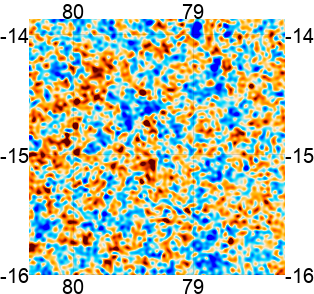

car:{cdelt:[0.008333,0.008333],crval:[0.004167,0],crpix:[-9388,1921]}


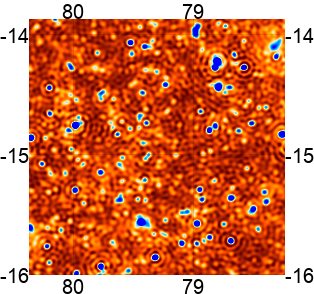

car:{cdelt:[0.008333,0.008333],crval:[0.004167,0],crpix:[-9388,1921]}


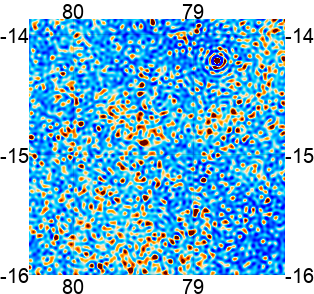

car:{cdelt:[0.008333,0.008333],crval:[0.004167,0],crpix:[-9388,1921]}


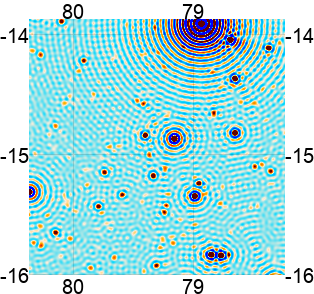

In [41]:
res_arcmin = 2.0
shape = (npix, npix)
stamp_dir = output_path("stamp_{}arcmin_{}x{}".format(res_arcmin, shape[0], shape[1]))

SS = maps.StampedSky(stamp_dir, res_arcmin, shape)

sim_idx = 1 

emap = SS.get_ksz(30, sim_idx)
print(emap.wcs)
enplot.pshow(emap, downgrade=1)

emap = SS.get_tsz(30, sim_idx)
print(emap.wcs)
enplot.pshow(emap, downgrade=1)

emap = SS.get_cib(30, sim_idx)
print(emap.wcs)
enplot.pshow(emap, downgrade=1)

emap = SS.get_radio(30, sim_idx)
print(emap.wcs)
enplot.pshow(emap, downgrade=1)
